# Assessing Wikipedia Bias

## Introduction

Wikipedia is one of the most widely used information platforms in the world, offering free access to knowledge on nearly every imaginable topic. One of the reasons it is so widely used is that anyone can contribute to it, and thus making it knowledge accessible, but also introduces challenges. Since so many different people contribute, it is easy for bias to slip into articles.

While Wikipedia does have policies to outright information, it is harder to catch and correct subtle bias in the way information is written. Thus, in reality language can reflect personal opinions, cultural viewpoints, or even political leanings. These influences can affect how information is presented, which might shape how readers understand a topic.

The goal of this project is to inverstigate and quantify this bias. Through a combination of data collection, exploratory data analysis (EDA), and supervised learning techniques, we aim to build a model capable of identifying biased language in Wikipedia articles - mostly at the sentence level. This will get us an overall 'bias score' for an article, offering a scalable and interpretable way to assess objectivity.

## Data Overview

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import random

#models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder


from wordcloud import WordCloud

import xgboost as xgb
from textblob import TextBlob

from sklearn.model_selection import GridSearchCV

from tqdm import tqdm

from transformers import BertTokenizer, BertModel
import torch
import math
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


### Useful Functions:

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def BERT_text_to_embeddings(texts, tokenizer, bert_model, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        ids_list.append(encoded['input_ids'].squeeze().tolist())
        attention_mask_list.append(encoded['attention_mask'].squeeze().tolist())

    device = torch.device(force_device) if force_device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    bert_model.to(device)

    if not disable_progress_bar:
        print(f'Using the {device} device.')

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size * i:batch_size * (i + 1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i:batch_size * (i + 1)]).to(device)

        with torch.no_grad():
            bert_model.eval()
            outputs = bert_model(input_ids=ids_batch, attention_mask=attention_mask_batch)

        embeddings.append(outputs.last_hidden_state[:, 0, :].detach().cpu().numpy())


    return np.concatenate(embeddings)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
def train_val_test_split (df, rstate = 42, shuffle=True, stratify=None):
    if stratify != None:
        strat=df[stratify]
    else:
        strat = None
    train_set, test_set = train_test_split(df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)

    if stratify!=None:
        strat=test_set[stratify]
    else:
        strat = None
    val_set, test_set=train_test_split(test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)

    return (train_set, val_set, test_set)

In [4]:
def get_bias_score(article_text, tokenizer, bert_model, classifier_model, biased_index=0):
    sentences = sent_tokenize(article_text)
    if not sentences:
        print('No sentences in file.')
        return 0.0

    embeddings = BERT_text_to_embeddings(sentences, tokenizer, bert_model)
    preds = classifier_model.predict(embeddings)
    predicted_classes = np.argmax(preds, axis=1)

    bias_score = np.mean(predicted_classes == biased_index)
    return round(bias_score, 3)


In [5]:
import requests

def get_wikipedia_article(title, lang='en'):
    """
    Robustly fetches the plain text content of a Wikipedia article using the MediaWiki API.
    Supports redirects and unusual titles.
    """
    api_url = f"https://{lang}.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "format": "json",
        "prop": "extracts",
        "explaintext": True,
        "redirects": 1,
        "titles": title
    }

    response = requests.get(api_url, params=params)
    data = response.json()

    pages = data["query"]["pages"]
    page = next(iter(pages.values()))

    if "extract" in page:
        return page["extract"]
    else:
        print(f"❌ Article not found: {title}")
        return None

In [6]:
# Load the datasets
try:
    data = pd.read_csv('/content/final_labels.csv', sep=';')
except:
    from google.colab import drive
    drive.mount('/content/drive')
    data = pd.read_csv('/content/drive/MyDrive/datasets/code_jam_may25/data/final_labels_SG2.csv', sep=';')

# Display the first few rows of the dataset
display(data.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,"""Orange Is the New Black"" star Yael Stone is r...",https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,Non-biased,Entirely factual,[]
1,"""We have one beautiful law,"" Trump recently sa...",https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,Biased,Somewhat factual but also opinionated,"['bizarre', 'characteristically']"
2,"...immigrants as criminals and eugenics, all o...",https://www.nbcnews.com/news/latino/after-step...,MSNBC,white-nationalism,left,Biased,Expresses writer’s opinion,"['criminals', 'fringe', 'extreme']"
3,...we sounded the alarm in the early months of...,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white-nationalism,left,Biased,Somewhat factual but also opinionated,[]
4,[Black Lives Matter] is essentially a non-fals...,http://feedproxy.google.com/~r/breitbart/~3/-v...,Breitbart,marriage-equality,NaN,Biased,Expresses writer’s opinion,['cult']


### Data preprocessing

In [7]:
# Display the column names of the dataset
column_names = data.columns.tolist()
display(column_names)

['text',
 'news_link',
 'outlet',
 'topic',
 'type',
 'label_bias',
 'label_opinion',
 'biased_words']

In [8]:
# Display the shape of the dataset
n_rows, n_cols = data.shape
print(f"The DataFrame has {n_rows} rows and {n_cols} columns")

The DataFrame has 3674 rows and 8 columns


In [9]:
# Display the informative summary of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3674 entries, 0 to 3673
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           3674 non-null   object
 1   news_link      3642 non-null   object
 2   outlet         3674 non-null   object
 3   topic          3674 non-null   object
 4   type           2674 non-null   object
 5   label_bias     3674 non-null   object
 6   label_opinion  3674 non-null   object
 7   biased_words   3674 non-null   object
dtypes: object(8)
memory usage: 229.8+ KB


In [10]:
# Display the descriptive statistics of the dataset

data.describe()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
count,3674,3642,3674,3674,2674,3674,3674,3674
unique,3674,2095,11,23,3,3,4,1623
top,YouTube is making clear there will be no “birt...,http://feedproxy.google.com/~r/breitbart/~3/2R...,Breitbart,marriage-equality,right,Non-biased,Entirely factual,[]
freq,1,15,943,347,993,1863,1600,1825


In [11]:
label_counts = data['label_bias'].value_counts()
valid_labels = label_counts[label_counts > 1].index

data = data[data['label_bias'].isin(valid_labels)]

## Explorating Data Analysis

### Duplicates

In [12]:
# Display the number of duplicates in the dataset
duplicates = data[data.duplicated()]
display(f"Number of duplicated data: {duplicates.shape[0]}")

'Number of duplicated data: 0'

### Missing Values

In [13]:
# Display the number of missing values in the dataset
display(data.isna().sum())

# Check for missing values in the DataFrame as a percentage
display(data.isna().sum()/len(data))

,0
text,0
news_link,32
outlet,0
topic,0
type,1000
label_bias,0
label_opinion,0
biased_words,0


,0
text,0.000000
news_link,0.008712
outlet,0.000000
topic,0.000000
type,0.272257
label_bias,0.000000
label_opinion,0.000000
biased_words,0.000000


In [14]:
# Drop rows with missing values in the 'news_link' and 'article' columns
data.dropna(subset=['news_link'], inplace=True)
data.dropna(subset=['type'], inplace=True)

<ipython-input-14-4104d514fc29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['news_link'], inplace=True)
<ipython-input-14-4104d514fc29>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['type'], inplace=True)


In [15]:
# Check for missing values in the DataFrame as a percentage
display(data.isna().sum()/len(data))

,0
text,0.0
news_link,0.0
outlet,0.0
topic,0.0
type,0.0
label_bias,0.0
label_opinion,0.0
biased_words,0.0


In [16]:
# Cleaning the text data in the 'text' column
# Define a function to clean the text data
def clear_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]","", text)
    text = text.split()
    return " ".join(text)

In [17]:
data['label_bias'] = data['label_bias'].str.lower()
data['topic'] = data['topic'].str.replace('-', ' ').str.lower()

<ipython-input-17-645c09649150>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label_bias'] = data['label_bias'].str.lower()
<ipython-input-17-645c09649150>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['topic'] = data['topic'].str.replace('-', ' ').str.lower()


In [18]:
data['biased_words'] = data['biased_words'].str.replace(r"[\[\]']", "", regex=True).str.replace(",", " ").str.strip()

In [19]:
data.columns

Index(['text', 'news_link', 'outlet', 'topic', 'type', 'label_bias',
       'label_opinion', 'biased_words'],
      dtype='object')

In [20]:
# Apply the clear_text function to the 'comment_text' column
data['clean_text'] = data['text'].astype(str).apply(clear_text)
data= data.drop(columns=['text'])

# Display the first 5 rows of the comments DataFrame after cleaning
display(data.sample(5))


,news_link,outlet,topic,type,label_bias,label_opinion,biased_words,clean_text
1890,https://www.alternet.org/2020/04/why-trump-is-...,Alternet,sport,left,biased,Expresses writer’s opinion,happy,of course the famously corrupted higher educat...
60,https://eu.usatoday.com/story/news/nation/2020...,USA Today,gender,center,non-biased,Entirely factual,,a gallup poll reports that women are still mor...
1074,https://www.breitbart.com/politics/2019/11/01/...,Breitbart,middle class,right,biased,Expresses writer’s opinion,gut stripped,free trade has helped gut working and middle c...
2148,http://feedproxy.google.com/~r/breitbart/~3/lM...,Breitbart,black lives matter,right,non-biased,Entirely factual,defaced,protesters defaced the monument early friday w...
2893,https://www.alternet.org/2020/01/trump-rule-ch...,Alternet,environment,left,non-biased,No agreement,,the rollback of national environmental policy ...


In [21]:
# Check for missing values
print(data['clean_text'].isna().sum())

0


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2643 entries, 0 to 3673
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   news_link      2643 non-null   object
 1   outlet         2643 non-null   object
 2   topic          2643 non-null   object
 3   type           2643 non-null   object
 4   label_bias     2643 non-null   object
 5   label_opinion  2643 non-null   object
 6   biased_words   2643 non-null   object
 7   clean_text     2643 non-null   object
dtypes: object(8)
memory usage: 185.8+ KB


In [23]:
  >>> import nltk
  >>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
## Set of English stop words
stop_words =  set(stopwords.words('english'))

In [25]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words]
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmas)

In [26]:

  >>> import nltk
  >>> nltk.download('punkt_tab')


  >>> import nltk
  >>> nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
# Apply the clear_text function to the 'comment_text' column
data['lemmatize_text'] = data['clean_text'].apply(lemmatize)

In [28]:
# Display the first rows of the comments DataFrame after cleaning
display(data[['clean_text', 'lemmatize_text']].head(20))

,clean_text,lemmatize_text
0,orange is the new black star yael stone is ren...,orange new black star yael stone renouncing u ...
1,we have one beautiful law trump recently said ...,one beautiful law trump recently said characte...
2,immigrants as criminals and eugenics all of wh...,immigrant criminal eugenics considered fringe ...
3,we sounded the alarm in the early months of tr...,sounded alarm early month trump presidency pri...
9,a new low washington post media critic blows u...,new low washington post medium critic blow tuc...
10,gangster capitalist trump is running a mafia s...,gangster capitalist trump running mafia state ...
11,the most progressive president since fdr biden...,progressive president since fdr bidens policy ...
18,the goal is to send a message of peace the yea...,goal send message peace yearold claimed insist...
20,you know theres over million people with preex...,know there million people preexisting conditio...
21,people were arrested for offences including as...,people arrested offence including assaulting p...


In [29]:
# Added a new column to convert 'biased' to 1 and 'non-biased' to 0
data['is_biased'] = data['label_bias'].apply(lambda x: 1 if x == 'biased' else 0)


In [30]:
# Making sure the new column 'is_biased' is present in the dataset
data.head()

,news_link,outlet,topic,type,label_bias,label_opinion,biased_words,clean_text,lemmatize_text,is_biased
0,https://www.foxnews.com/entertainment/australi...,Fox News,environment,right,non-biased,Entirely factual,,orange is the new black star yael stone is ren...,orange new black star yael stone renouncing u ...,0
1,https://www.alternet.org/2020/06/law-and-order...,Alternet,gun control,left,biased,Somewhat factual but also opinionated,bizarre characteristically,we have one beautiful law trump recently said ...,one beautiful law trump recently said characte...,1
2,https://www.nbcnews.com/news/latino/after-step...,MSNBC,white nationalism,left,biased,Expresses writer’s opinion,criminals fringe extreme,immigrants as criminals and eugenics all of wh...,immigrant criminal eugenics considered fringe ...,1
3,https://www.alternet.org/2019/07/fox-news-has-...,Alternet,white nationalism,left,biased,Somewhat factual but also opinionated,,we sounded the alarm in the early months of tr...,sounded alarm early month trump presidency pri...,1
9,https://www.alternet.org/2019/08/a-new-low-was...,Alternet,white nationalism,left,biased,Expresses writer’s opinion,blows up absurd lies nationalism white,a new low washington post media critic blows u...,new low washington post medium critic blow tuc...,1


In [31]:
# Display the shape of the dataset after completing EDA.
n_rows, n_cols = data.shape
print(f"The DataFrame has {n_rows} rows and {n_cols} columns")

The DataFrame has 2643 rows and 10 columns


### Conclusion: Data Preprocessing and EDA

In this part, we conducted a thorough preprocessing and exploratory data analysis (EDA) to prepare the dataset for bias detection modeling. Firstly, we reviewed the dataset's structure, identifying the number of rows and columns, and inspecting its basic information and summary statistics. We then addressed data quality issues, including duplicates, and handling missing values. Doing this, there were no duplicates found in the data, while missing values were found in two columns 'news_link' and 'type' in negligible percentage of the dataset. Thus, rows will missing values were dropped.

Next, we focused on cleaning and standarizing the text data. This included lowercasing, removing URLs, special characters, and stopwords, as well as lemmatizing words to reduce them to their root forms. These steps help normalize the text and reduce noise, which is essential for any NLP-based modeling.

To better analyze bias, we created a binary label column ('is_biased') to distinguish between biased and unbiased texts. This will serve as our target variable in supervised which will be used as input features for further linguistic anaylsis and model training.

Overall, the dataset is now well-structured, cleaned, and ready for feature extraction, model building, and further investigation into biased language patterns.

#### Which topics have the most biased words on average per article?

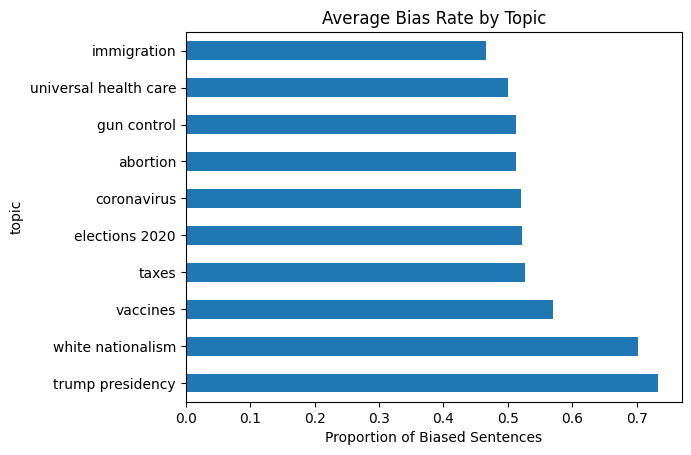

In [32]:
bias_by_topic = data.groupby('topic')['is_biased'].mean().sort_values(ascending=False).head(10)
bias_by_topic.plot(kind='barh')
plt.title('Average Bias Rate by Topic')
plt.xlabel('Proportion of Biased Sentences')
plt.show()

The graph above reveals that certain topics attract more biased language than others. 'Trump presidency' and 'white nationalism' have the highest average bias rates, with over 70% of sentences labeled as biased. These findings suggest that politically and socially charged topics are more prone to emotionally loaded language. On the other hand, topics like 'immigration', 'universal healthercare', and 'gun control' show lower bias rates, though they still remain near 45-50%, indicating that even these texts are not free from bias.

Understanding which topics are more likely to contain biased language helps contextualize the limitations of people-contributed platforms like Wikipedia and can inform targeted moderation or review efforts.

#### Is the dataset balanced between biased and unbiased data rows?

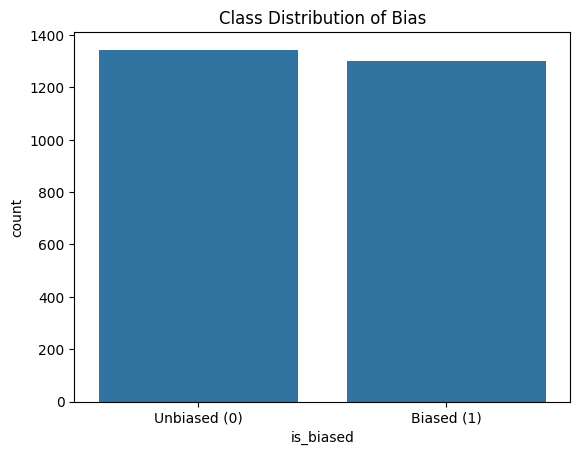

In [33]:
sns.countplot(x='is_biased', data=data)
plt.title('Class Distribution of Bias')
plt.xticks([0,1], ['Unbiased (0)', 'Biased (1)'])
plt.show()

The graph indicates that the dataset is nearly balanced, with a slightly higher number of unbiased (0) data rows compared to biased (1). This is ideal for supervising learning, as a balanced dataset helps prevent the model from becoming biased toward the majority class. It increases the likelihood of accurate predictions for both biased and unbiased text during model training and evaluation.

#### Which words are most frequently flagged as biased across the dataset?

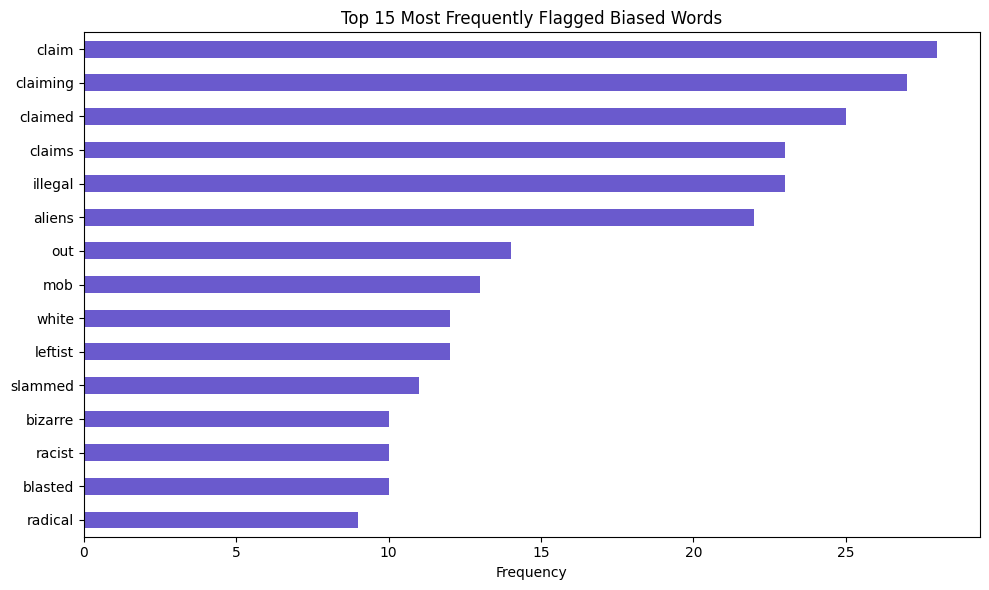

In [34]:
all_biased_words = data['biased_words'].dropna().astype(str).str.split()

all_biased_words = [word for sublist in all_biased_words for word in sublist]

top_words = pd.Series(all_biased_words).value_counts().head(15)

excluded_words = ['the', 'of']

# Count top words, then filter out the excluded ones
top_words = (
    pd.Series(all_biased_words)
    .value_counts()
    .drop(labels=excluded_words, errors='ignore')  # drop excluded
    .head(15)
)

# Plot
top_words.plot(kind='barh', figsize=(10,6), color='slateblue')
plt.xlabel('Frequency')
plt.title('Top 15 Most Frequently Flagged Biased Words')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [35]:
top_words.head(25)

,count
claim,28
claiming,27
claimed,25
claims,23
illegal,23
aliens,22
out,14
mob,13
white,12
leftist,12


#### How does sentiment differ between biased and unbiased texts?

MRCP_Concereteness_Ratings is a rating of  tangiblility of a word.
MRCP_Imagability_Ratings is how easily a word evokes a mental image.

Overall these ideas are connected so that:
Low concreteness + high imagability can suggest emotional or persuasive bias.
High concreteness + low imagability often points to factual reporting.


#### What proportion of an article's sentences are labeled as biased or opinionated?

In [36]:
data['sentiment'] = data['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)


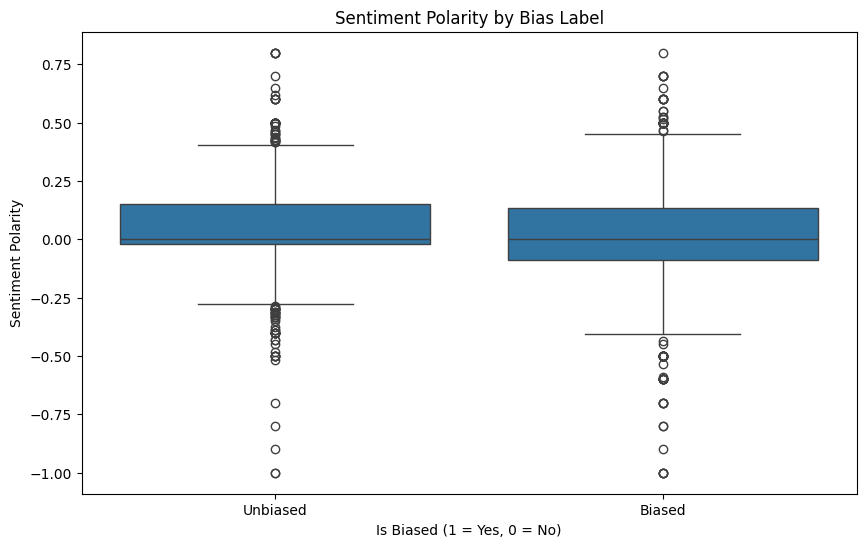

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_biased', y='sentiment', data=data)
plt.title('Sentiment Polarity by Bias Label')
plt.xlabel('Is Biased (1 = Yes, 0 = No)')
plt.ylabel('Sentiment Polarity')
plt.xticks([0, 1], ['Unbiased', 'Biased'])
plt.show()

The graph above analyzes the sentiment polarity across biased and unbiased text of different articles. It reveals that while both categories generally maintain fa neutral tone on average, biased articles tend to exhibit a wider range of sentiment. This includes a higher frequency of strongly positive or negative sentiment, indicating that biased writing often uses more emotionally charge language. In contrast, unbiased texts shows a tighter sentiment distribution, reflecting a more balanced and objective tone. This suggests that sentiment polarity can serve as a useful signal in detecting bias, particularly when combined with other linguistic and contextual features.

#### Which news outlet have the highest average bias score?



In [38]:
avg_bias_by_outlet = data.groupby('outlet')['is_biased'].mean().sort_values(ascending=False).reset_index()

# Display top outlets by average bias score
print(avg_bias_by_outlet.head())

       outlet  is_biased
0    Alternet   0.720379
1  Federalist   0.720000
2   Breitbart   0.592868
3    HuffPost   0.539823
4       MSNBC   0.411765


<ipython-input-39-1473ec452d49>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_bias_by_outlet, x='outlet', y='is_biased', palette='Reds_r')


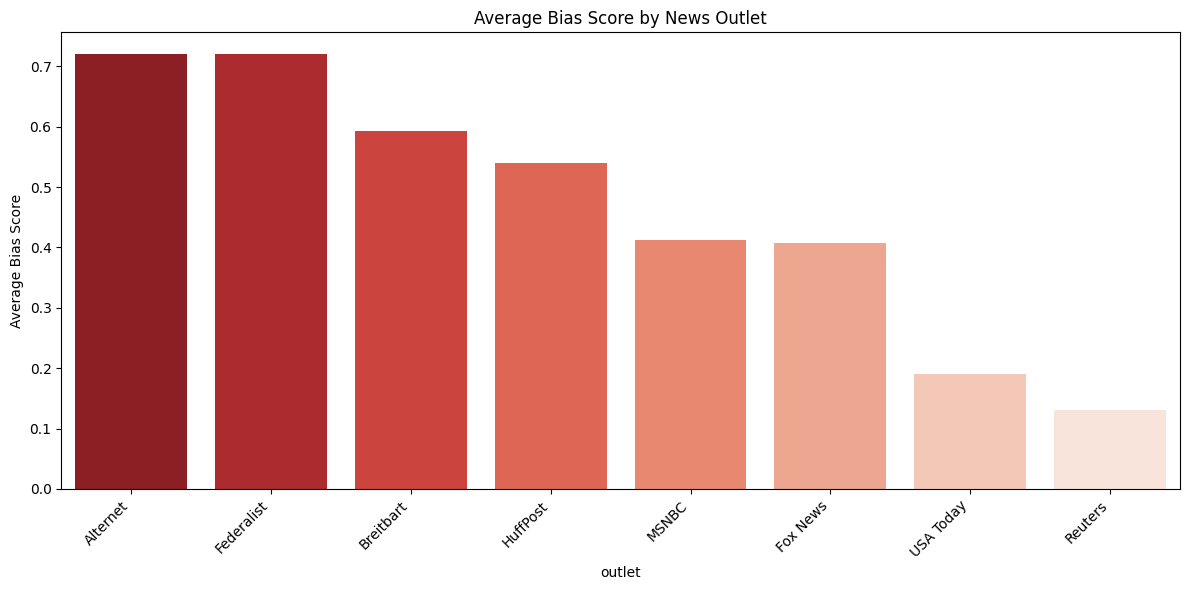

In [39]:

plt.figure(figsize=(12,6))
sns.barplot(data=avg_bias_by_outlet, x='outlet', y='is_biased', palette='Reds_r')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Bias Score')
plt.title('Average Bias Score by News Outlet')
plt.tight_layout()
plt.show()

The bar graph displays the average proportion of biased sentences per article across different news outlets. The data suggests that media outlets vary widely in how frequently they use biased language. Alternet and Federalist have the highest average bias scores, suggesting strong ideological framing. Breitbart and HuffPost also show high bias, while MSNBC and Fox News despite opposing views - have similar moderate scores.Reuters and USA Today stand out for their low bias, reflecting more neutral reporting. Overall, outlets with a strong ideological orientation tend to have higher bias scores, whereas mainstream or centrist outlets tend to score lower. In particular, Reuters stands out for having the most neutral tone in its reporting.

## Modeling

In [40]:
# Before modeling, checking the total counts for 'biased' and 'non-biased'.
data['is_biased'].value_counts()

,count
is_biased,
0,1344
1,1299


In [41]:
data.columns

Index(['news_link', 'outlet', 'topic', 'type', 'label_bias', 'label_opinion',
       'biased_words', 'clean_text', 'lemmatize_text', 'is_biased',
       'sentiment'],
      dtype='object')

In [42]:
# Only keeping input and output
df = data[['clean_text', 'label_bias']]

In [43]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label_bias'])


<ipython-input-43-dbcf99169fb4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label_encoded'] = le.fit_transform(df['label_bias'])


In [44]:
df.columns

Index(['clean_text', 'label_bias', 'label_encoded'], dtype='object')

In [45]:
# Splitting in train and test (from Tirso)
# Remove stratification if a class has only one instance
if df['label_encoded'].nunique() > 1 and df['label_encoded'].value_counts().min() >= 2:
    train_set, val_set, test_set = train_val_test_split(df, stratify='label_encoded')
else:
    # If stratification is not possible, perform a regular split
    train_set, val_set, test_set = train_val_test_split(df)

xtrain, ytrain = train_set['clean_text'], train_set['label_encoded']
xval, yval = val_set['clean_text'], val_set['label_encoded']
xtest, ytest = test_set['clean_text'], test_set['label_encoded']

# Splitting in train and test (from Tirso)
#train_set, val_set, test_set = train_val_test_split(df, stratify='label_encoded')
#xtrain, ytrain = train_set['clean_text'], train_set['label_encoded']
#xval, yval = val_set['clean_text'], val_set['label_encoded']
#xtest, ytest = test_set['clean_text'], test_set['label_encoded']

### BERT Model:

In [46]:
xtrain

,clean_text
2469,thanks to the gops commitment to voter suppres...
1950,opposition labour party leader jeremy corbyn s...
1878,ocasiocortez sworn in as congress youngest mem...
539,black lives matter activists in chicago held a...
436,at around am however trump sent out a tweet th...
...,...
2163,putin remains popular with many russians altho...
2836,the police lynching of george floyd provoked w...
1529,its also a function of the moral hazard that a...
1350,in every case legislators are being swarmed by...


In [48]:
embeddings_train = BERT_text_to_embeddings(xtrain, tokenizer, bert_model)
embeddings_val = BERT_text_to_embeddings(xval, tokenizer, bert_model)
embeddings_test = BERT_text_to_embeddings(xtest, tokenizer, bert_model)


Using the cuda device.


100%|██████████| 16/16 [00:40<00:00,  2.53s/it]


Using the cuda device.


100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


Using the cuda device.


100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


In [49]:
print(le.classes_)
print(type(le.classes_[0]))

['biased' 'non-biased']
<class 'str'>


### TF-IDF & Logistic Regression:

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    data['lemmatize_text'], data['is_biased'], test_size=0.2, random_state=42
)

In [51]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [52]:
X_train.shape

(2114,)

In [53]:
X_train_vec.shape

(2114, 5000)

In [54]:
y_train.shape

(2114,)

In [55]:
model = LogisticRegression()
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7069943289224953
[[195  78]
 [ 77 179]]
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       273
           1       0.70      0.70      0.70       256

    accuracy                           0.71       529
   macro avg       0.71      0.71      0.71       529
weighted avg       0.71      0.71      0.71       529



In [56]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

In [57]:
model_rf = RandomForestClassifier(random_state=7)

grid_search = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=2,
)

grid_search.fit(X_train_vec, y_train)

print("Best Parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_vec)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_dep

In [58]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6899810964083176
[[189  84]
 [ 80 176]]
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       273
           1       0.68      0.69      0.68       256

    accuracy                           0.69       529
   macro avg       0.69      0.69      0.69       529
weighted avg       0.69      0.69      0.69       529



In [59]:
param_grid = {
    'n_estimators': [50, 100,],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 3],
}

## XGB Classifier:

In [ ]:
model_xg = XGBClassifier(eval_metric='logloss')

grid_search = GridSearchCV(estimator=model_xg, param_grid=param_grid,
                           scoring='f1', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train_vec, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

## LGBM Classifier:

In [60]:
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100],
    'max_depth': [-1, 10, 20],
}

In [61]:
model_lg = LGBMClassifier(eval_metric='logloss')

grid_search = GridSearchCV(estimator=model_lg, param_grid=param_grid,
                           scoring='f1', cv=3, verbose=1)

grid_search.fit(X_train_vec, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vec)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 196
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493617 -> initscore=-0.025533
[LightGBM] [Info] Start training from score -0.025533
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001842 seconds.
You can set `fo

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overh

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of da

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_row_wise

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 196
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493617 -> initscore=-0.025533
[LightGBM] [Info] Start training from score -0.025533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overh

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001732 seconds.
You can set `fo

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 196
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493617 -> initscore=-0.025533
[LightGBM] [Info] Start training from score -0.025533
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overh

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overh

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001773 seconds.
You can set `fo

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 196
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493617 -> initscore=-0.025533
[LightGBM] [Info] Start training from score -0.025533
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if me

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overh

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 196
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493617 -> initscore=-0.025533
[LightGBM] [Info] Start training from score -0.025533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 196
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493617 -> initscore=-0.025533
[LightGBM] [Info] Start training from score -0.025533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2972
[LightGBM] [Info] Number of data points in the train set: 1410, number of used features: 196
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493617 -> initscore=-0.025533
[LightGBM] [Info] Start training from score -0.025533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 696, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3108
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 695, number of negative: 714
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3056
[LightGBM] [Info] Number of data points in the train set: 1409, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493258 -> initscore=-0.026971
[LightGBM] [Info] Start training from score -0.026971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [62]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6729678638941399
[[180  93]
 [ 80 176]]
              precision    recall  f1-score   support

           0       0.69      0.66      0.68       273
           1       0.65      0.69      0.67       256

    accuracy                           0.67       529
   macro avg       0.67      0.67      0.67       529
weighted avg       0.67      0.67      0.67       529



## Neural Network with Keras

In [63]:
ytrain_nn = ytrain.values
yval_nn = yval.values
ytest_nn = ytest.values

In [64]:
model = Sequential([
    Dense(512, activation='gelu', input_shape=(embeddings_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='gelu'),
    Dropout(0.3),
    Dense(len(set(ytrain)), activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    embeddings_train, ytrain,
    validation_data=(embeddings_val, yval),
    epochs=60,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.5508 - loss: 0.6928 - val_accuracy: 0.7013 - val_loss: 0.5888
Epoch 2/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6997 - loss: 0.5837 - val_accuracy: 0.6994 - val_loss: 0.5828
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6976 - loss: 0.5706 - val_accuracy: 0.7259 - val_loss: 0.5555
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7339 - loss: 0.5423 - val_accuracy: 0.7221 - val_loss: 0.5567
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7367 - loss: 0.5243 - val_accuracy: 0.7335 - val_loss: 0.5501
Epoch 6/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7636 - loss: 0.4930 - val_accuracy: 0.7278 - val_loss: 0.5501
Epoch 7/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7739 - loss: 0.4697 - val_accuracy: 0.7183 - val_loss: 0.5532
Epoch 8/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7578 - loss: 0.4759 - val_accuracy: 0.7032 - val_loss

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


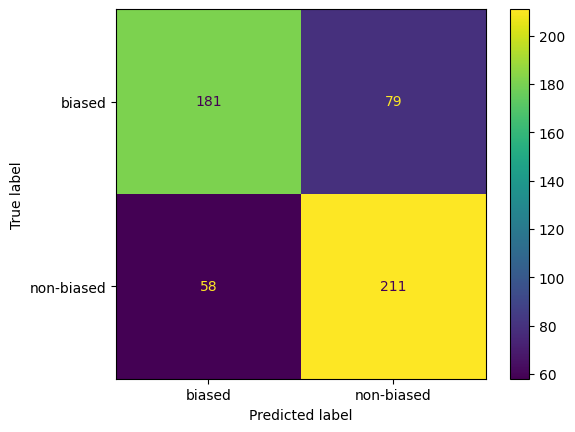

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ypred = model.predict(embeddings_test).argmax(axis=1)
ConfusionMatrixDisplay.from_predictions(ytest, ypred, display_labels=le.classes_)

The neural network is the best performing one so this will be used.

## 4. You need to have a prediction function that can take in a new wikipedia article and predict how biased it is. You can do this by predicting if each sentence in an article is biased, then perhaps scaling the results by the length of the article to get somewhat of a “bias score”

In [67]:
article_text = get_wikipedia_article("2024 United States presidential election")
bias_score = get_bias_score(
    article_text=article_text,
    tokenizer=tokenizer,
    bert_model=bert_model,
    classifier_model=model,
    biased_index=0
)
print("Bias Score:", bias_score)


Using the cuda device.


100%|██████████| 6/6 [00:16<00:00,  2.68s/it]

 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Bias Score: 0.079


In [ ]:
print("Label mapping:", list(le.classes_))

In [ ]:
article_text = get_wikipedia_article("2024 United States presidential election")

print(article_text)

In [ ]:
if article_text:
   bias_score = get_bias_score(article_text, bert_model=bert_model, classifier_model=model, le=le) # Corrected argument order
   print("Bias score:", bias_score)


In [ ]:
lemmatizer = WordNetLemmatizer()

def clean_and_lemmatize(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = text.split()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized)

sentences = sent_tokenize(article_text)
cleaned_sentences = [clean_and_lemmatize(s) for s in sentences]

In [ ]:
display(cleaned_sentences)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
# Fit the vectorizer to training data (e.g., cleaned_sentences)
vectorizer.fit(cleaned_sentences) # this line is added to fit the vectorizer
x_article_vec = vectorizer.transform(cleaned_sentences) #then we can transform the data

In [ ]:
# Get BERT embeddings for the sentences
embeddings_article = BERT_text_to_embeddings(cleaned_sentences)

# Make predictions using the Keras model
predictions = model.predict(embeddings_article)

# Calculate bias score
bias_score = predictions.sum() / len(predictions)
#change 2
#predictions = model.predict(x_article_vec)

In [ ]:
bias_score = predictions.sum() / len(predictions)

In [ ]:
df_sent = pd.Series(sentences, name='sentence')
df_clean = pd.Series(cleaned_sentences, name='cleaned')
# Extract the predicted probabilities for the 'biased' class (assuming it's the second class)
df_pred = pd.Series(predictions[:, 1], name='is_biased')
results_df = pd.concat([df_sent, df_clean, df_pred], axis=1)

In [ ]:
bias_score = results_df['is_biased'].sum() / len(results_df)

bias_score = round(bias_score, 2)

print(f"Bias Score for this article: {bias_score}")

In [ ]:
#Bubble chart showing article distribution across bias types

#results_df is  DataFrame with 'sentence', 'cleaned', and 'is_biased' columns
plt.figure(figsize=(10, 6))
plt.scatter(results_df.index, results_df['is_biased'], s=results_df['is_biased'] * 100, alpha=1)  # Adjust marker size as needed
plt.xlabel('Sentence Index')
plt.ylabel('Bias Probability')
plt.title('Bias Probability Distribution across Sentences')
plt.grid(True)
plt.show()


In [ ]:
# def get_sentiment(text):
#    return TextBlob(text).sentiment.polarity

#data['biased_score'] = data['clean_text'].apply(get_sentiment)
#data['biased_label'] = data['biased_score'].apply(lambda x: 'biased' if x > 0 else 'unbiased')